# Compress then explain: example with SHAP

Example of CTE with the [`shap` Python package](https://github.com/shap/shap) explaining a neural network trained on the `heloc` dataset.

#### load packages

In [1]:
import numpy as np
from openxai.dataloader import ReturnLoaders
from openxai.model import LoadModel
from goodpoints import compress
import shap

#### load the dataset and model

In [2]:
_, loader_test = ReturnLoaders(data_name="heloc", download=False, batch_size=128)
X_test = loader_test.dataset.data
model = LoadModel(data_name="heloc", ml_model="ann", pretrained=True)
model.eval()
n = X_test.shape[0]
d = X_test.shape[1]
sigma = np.sqrt(2 * d)

#### compress background data

In [3]:
id_cte = compress.compresspp_kt(X_test, kernel_type=b"gaussian", k_params=np.array([sigma**2]), g=4, seed=0)
X_cte = X_test[id_cte]

#### then explain

In [4]:
masker_cte = shap.maskers.Independent(X_cte, max_samples=X_cte.shape[0])
explainer_cte = shap.PermutationExplainer(lambda x: model.predict_proba(x)[:, 1], masker_cte, seed=0)
shap_cte = explainer_cte(X_test)

PermutationExplainer explainer: 1976it [00:12, 28.25it/s]                           


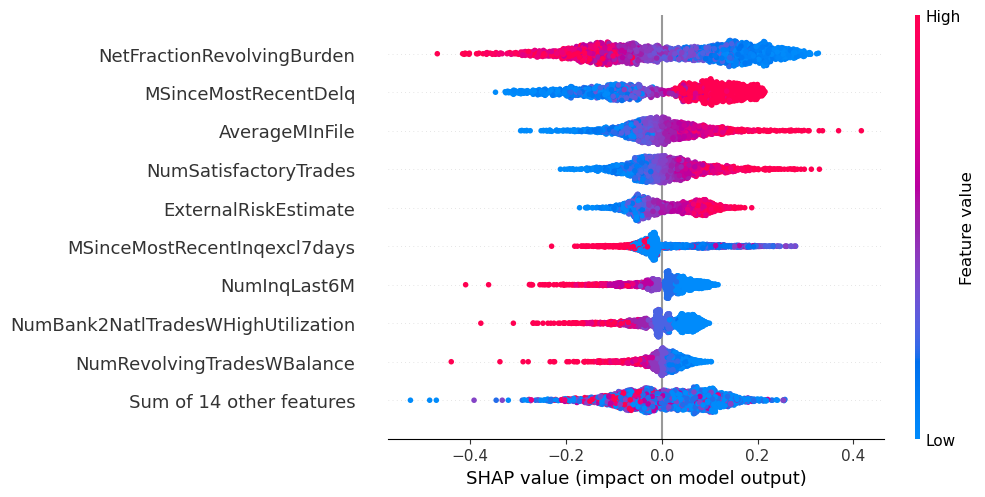

In [5]:
shap_cte.feature_names = loader_test.dataset.feature_names
shap.plots.beeswarm(shap_cte)

#### compare with iid sampling

In [6]:
np.random.seed(0)
id_iid = np.random.choice(n, size=len(id_cte))
X_iid = X_test[id_iid]

In [7]:
masker_iid = shap.maskers.Independent(X_iid, max_samples=X_iid.shape[0])
explainer_iid = shap.PermutationExplainer(lambda x: model.predict_proba(x)[:, 1], masker_iid, seed=0)
shap_iid = explainer_iid(X_test)

PermutationExplainer explainer: 1976it [00:11, 19.00it/s]                           


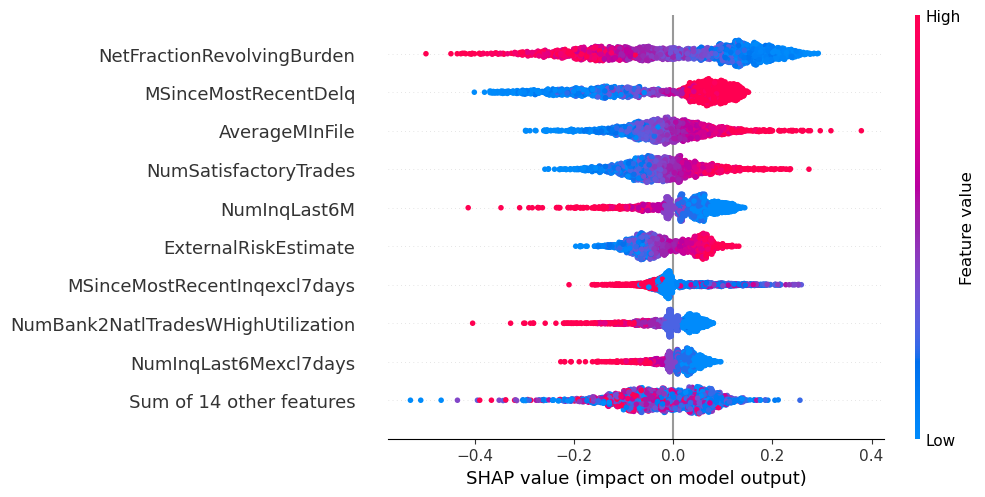

In [8]:
shap_iid.feature_names = loader_test.dataset.feature_names
shap.plots.beeswarm(shap_iid)

#### calculate "ground truth"

In [9]:
masker_gt = shap.maskers.Independent(X_test, max_samples=X_test.shape[0])
explainer_gt = shap.PermutationExplainer(lambda x: model.predict_proba(x)[:, 1], masker_gt, seed=0)
shap_gt = explainer_gt(X_test)

PermutationExplainer explainer: 1976it [06:23,  5.02it/s]                          


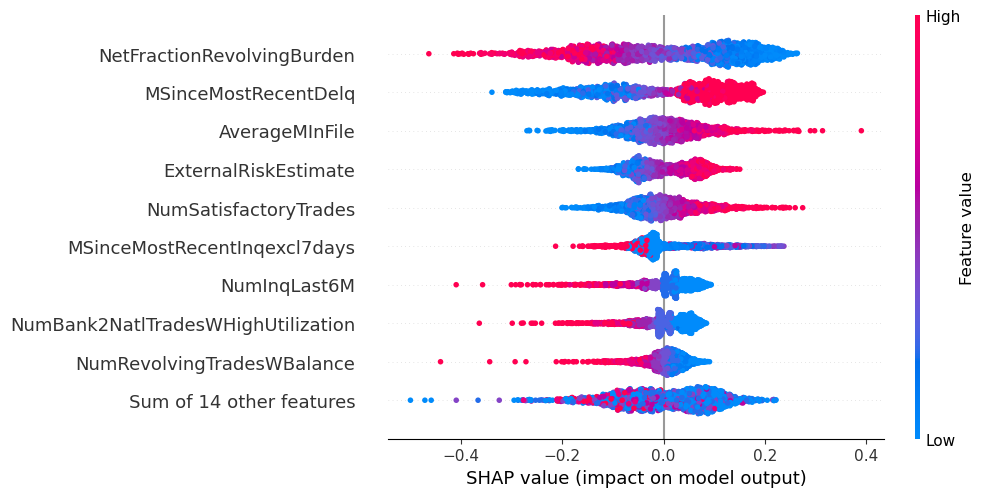

In [10]:
shap_gt.feature_names = loader_test.dataset.feature_names
shap.plots.beeswarm(shap_gt)

#### evaluate

In [11]:
def metric_mae(x, y):
    return np.mean(np.abs(x-y))

In [12]:
print(f'Explanation approximation error introduced by iid sampling:\
      {metric_mae(shap_gt.values, shap_iid.values):.4f}')
print(f'Relative improvement by CTE:\
      {100*(metric_mae(shap_gt.values, shap_iid.values) - metric_mae(shap_gt.values, shap_cte.values)) / metric_mae(shap_gt.values, shap_iid.values):.2f}%')

Explanation approximation error introduced by iid sampling:      0.0087
Relative improvement by CTE:      38.46%
